#### This is a time series analysis on power comsumption. The original data is hour-unit. Since the data lasts over 10 years, I use the monthly data as basic unit. Exponential Smoothing and Seasonal ARIMA are two models used here. We will use average monthly consumption from 2005 to 2016 to predict 2017's average monthly consumption. 

Kaggle Dataset https://www.kaggle.com/robikscube/hourly-energy-consumption

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.rcParams['figure.figsize'] = (12.0, 5.0)
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('AEP_hourly.csv.zip', index_col = 0,parse_dates=[0])

In [5]:
start_date = str(df.index.min())
end_date = str(df.index.max())
print ('This hourly power consumption dataset ranges from ' + start_date + ' to ' + end_date +'.')

This hourly power consumption dataset ranges from 2004-10-01 01:00:00 to 2018-08-03 00:00:00.


In [6]:
df = df.sort_index()
df_sub = df.loc[pd.Timestamp('2005-01-01'):pd.Timestamp('2017-12-31')]
start_date = str(df_sub.index.min())
end_date = str(df_sub.index.max())
print ('This new hourly power consumption dataset ranges from ' + start_date + ' to ' + end_date +'.')

This new hourly power consumption dataset ranges from 2005-01-01 00:00:00 to 2017-12-31 00:00:00.


In [7]:
df_sub.sort_index().head()

,AEP_MW
Datetime,
2005-01-01 00:00:00,12892.0
2005-01-01 01:00:00,12316.0
2005-01-01 02:00:00,11890.0
2005-01-01 03:00:00,11579.0
2005-01-01 04:00:00,11461.0


#### Transform hourly into monthly

In [8]:
df_by_mon = df_sub.groupby(df_sub.index.to_period('M')).mean()

In [9]:
df_by_mon.head()

,AEP_MW
Datetime,
2005-01,17117.088710
2005-02,16496.644345
2005-03,15924.061828
2005-04,14032.422809
2005-05,13685.072581


In [10]:
print (df_by_mon.describe())

             AEP_MW
count    156.000000
mean   15519.146958
std     1482.159194
min    12805.127688
25%    14356.824762
50%    15330.416187
75%    16704.216062
max    19212.903274


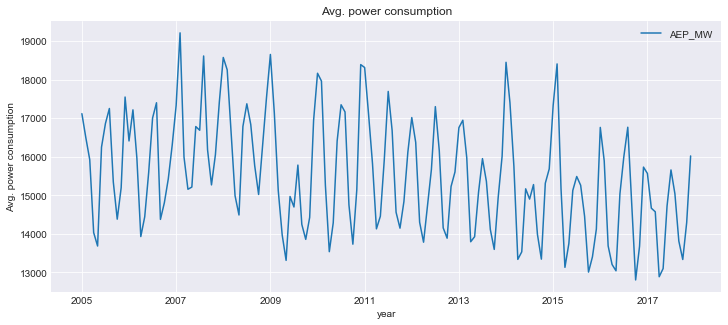

In [11]:
sns.set_style('darkgrid')
df_by_mon.plot()
plt.xlabel('year')
plt.ylabel('Avg. power consumption')
plt.title('Avg. power consumption')
plt.show()

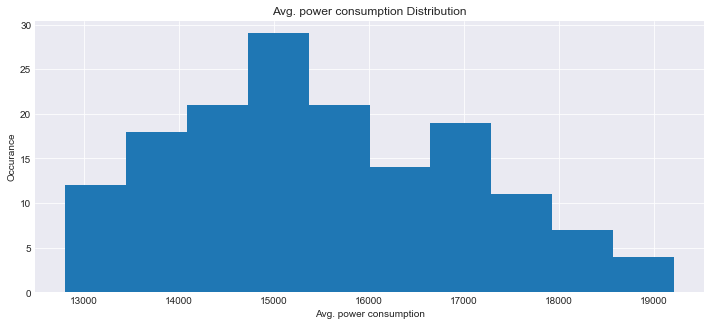

Right skewed --- outliers existed


In [12]:
df_by_mon.hist()
plt.xlabel('Avg. power consumption')
plt.ylabel('Occurance')
plt.title('Avg. power consumption Distribution')
plt.show()
print ('Right skewed --- outliers existed')

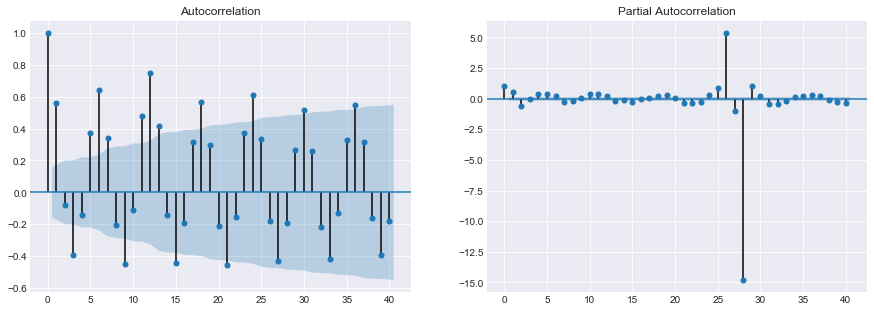

ACF is decaying slowly, which means this Time Series seams to be non-stationary. We can verify it using Dickey-Fuller test


In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(df_by_mon['AEP_MW'], lags=40,ax=ax[0])
plot_pacf(df_by_mon['AEP_MW'], lags=40,ax=ax[1])
plt.show()
print('ACF is decaying slowly, which means this Time Series seams to be non-stationary. We can verify it using Dickey-Fuller test')

In [14]:
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

check_adfuller(df_by_mon['AEP_MW'])

Test statistic:  -1.4255120540223842
p-value:  0.5699860661149482
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}


#### We use statistic to verify: Test statistic is less than critial value and P value is greater than 0.05, so we can say this is a non-stationary Time series. Since the Times series seems to have seasonal peaks and trends, we can decompose it into level, trend, seasonality and noise components. 

In [15]:
df_by_mon.interpolate(inplace = True)
df_by_mon.index=df_by_mon.index.to_timestamp()

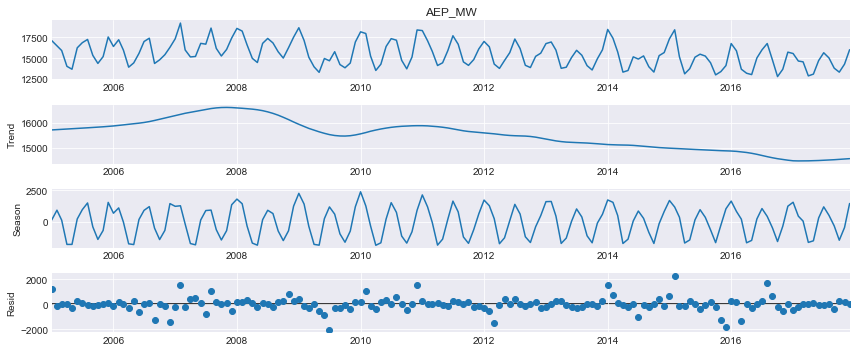

Residual are around 0 with constant variance, so we can be sure there are seasonality and trend patterns in this time series.


In [16]:
stl = STL(df_by_mon['AEP_MW'], period=12, robust=True)
res_robust = stl.fit()
res_robust.plot()
plt.show()
print('Residual are around 0 with constant variance, so we can be sure there\
 are seasonality and trend patterns in this time series.')

In [17]:
# Train-Test Split 
data = df_by_mon['AEP_MW']['2005-1':'2016-12']
test = df_by_mon['AEP_MW']['2017-1':]

In [18]:
# we can use MAPE to compare models
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Exponential Smoothing Model

In [19]:
def Exponential_Smoothing_model (train, test):
    ets_stl = ExponentialSmoothing(train,seasonal_periods=12,trend='add', seasonal='add').fit()
    ets_stl1 = ets_stl.forecast(len(test))
    Eps_mape = round(mean_absolute_percentage_error(test.values, ets_stl1.values),4)
    
    results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$"])
    params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
    results["Additive"] = [round(ets_stl.params[p],4) for p in params]
    
    ax = train.plot(marker='o', color='black', title="Forecasts from Holt-Winters' additive method" + " Mean Absolute Percentage Error: {0:.2f}%".format(Eps_mape))
    ax.set_ylabel("Power comsuption")
    ax.set_xlabel("Year")
    ets_stl.fittedvalues.plot(ax=ax, style='--', color='red')
    
    future_forecast = pd.DataFrame(ets_stl1,columns=['Holt-Winters (add-add-seasonal) Prediction'])
    future_forecast.plot(ax=ax, style='--', marker='o', color='red', legend=True, label = 'Test Forecast')
    test.plot(ax=ax, style='--', marker='o',color='green',legend=True, label = 'Test Actual')

    return results

,Additive
$\alpha$,0.3647
$\beta$,0.0000
$\phi$,NaN
$\gamma$,0.0000
$l_0$,17115.8217
$b_0$,0.0927


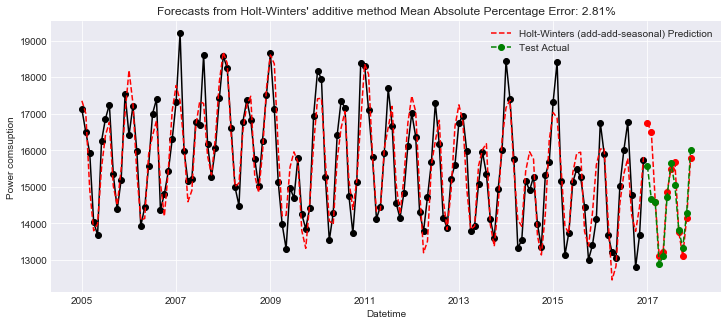

In [20]:
Exponential_Smoothing_model(data, test)

### ARIMA Model

In [21]:
check_adfuller(data)

Test statistic:  -1.709220893782166
p-value:  0.426367966648644
Critical Values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}


In [22]:
### seasonal difference and stationary test
def sea_diff (train):
    mon_sea_diff = train- train.shift(12)
    mon_sea_diff = mon_sea_diff.dropna()
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    mon_sea_diff.plot(kind="line",ax = ax[0])
    
    plot_acf(mon_sea_diff, lags=40,ax = ax[1])
    plot_pacf(mon_sea_diff, lags=40,ax = ax[2])
    
    results = check_adfuller(mon_sea_diff)
    plt.show()
    return results

Test statistic:  -3.885241130064872
p-value:  0.0021461894304129264
Critical Values: {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


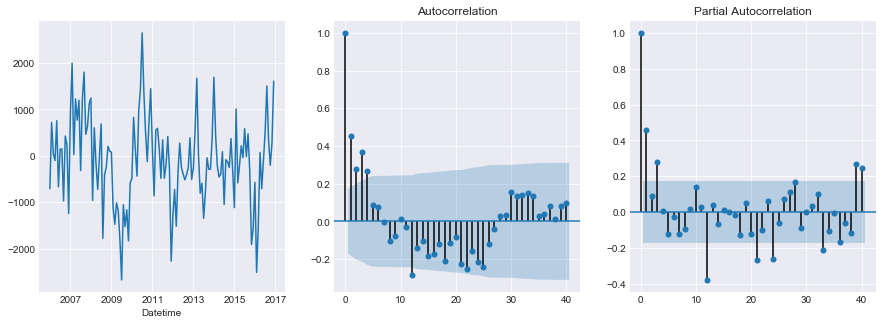

P-value is less than .05, so the series is stationary after differencing.


In [23]:
sea_diff(data)
print ('P-value is less than .05, so the series is stationary after differencing.')

In [24]:
stepwise_model = pm.auto_arima(data, start_p=1, start_q=1,
                                   max_p=3, max_q=3, m=12,
                                   start_P=0, seasonal=True,
                                   d=1, D=1, trace=True,
                                   error_action='ignore',  
                                   suppress_warnings=True, 
                                   stepwise=True)
stepwise_model.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2116.019, BIC=2130.395, Fit time=0.691 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2177.754, BIC=2183.504, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2137.222, BIC=2148.723, Fit time=0.247 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2115.218, BIC=2126.719, Fit time=0.459 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2108.927, BIC=2123.303, Fit time=0.644 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=2130.279, BIC=2141.780, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2118.465, BIC=2135.716, Fit time=1.779 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2152.194, BIC=2160.819, Fit time=0.124 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=2119.535, BIC=2139.662, Fit time=1.934 seconds
Fit ARIMA: order=(1, 1, 1) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1049.463
Date:                            Sun, 31 May 2020   AIC                           2108.927
Time:                                    15:02:34   BIC                           2123.303
Sample:                                         0   HQIC                          2114.768
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.8593      8.699     -1.133      0.257     -26.909       7.191
ma.L1         -0.4118      0.068     -6.094      0.000      -0.544      -0.279
ar.S.L12       0.2351      0.120      1.952      0.051      -0.001       0.471
ma.S.L12      -0.9866      1.355     -0.728      0.467      -3.643       1.669
sigma2      4.122e+05   5.48e+05      0.753      0.452   -6.61e+05    1.49e+06
===================================================================================
Ljung-Box (Q):                       47.53   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.19   Prob(JB):                         0.45
Heteroskedasticity (H):               0.86   Skew:                             0.15
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
check_adfuller(stepwise_model.resid())

Test statistic:  -11.141934286031425
p-value:  3.0927657626542606e-20
Critical Values: {'1%': -3.477261624048995, '5%': -2.8821181874544233, '10%': -2.5777431104939494}


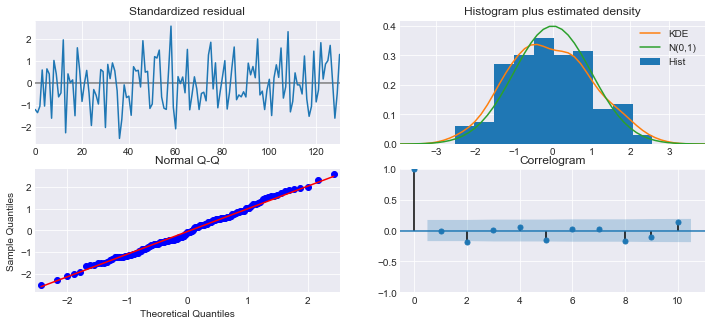

In [26]:
stepwise_model.plot_diagnostics()
plt.show()

In [27]:
def auto_arima_model_plot (train, test): 

    train_forecast = stepwise_model.predict_in_sample(train, start=0, end=len(train))
    future_forecast = stepwise_model.predict(len(test))
    mape = round(mean_absolute_percentage_error(test.values, future_forecast),4)
    
    ax = train.plot(marker='o', color='black', title="Forecasts from SARIMA method" + " Mean Absolute Percentage Error: {0:.2f}%".format(mape) )
    ax.set_ylabel("Power comsuption")
    ax.set_xlabel("Year")
    pd.DataFrame(train_forecast[1:],index = train.index,columns=['Train Fitted']).plot(ax=ax, style='--', color='red')
    
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Test Forecast'])
    future_forecast.plot(ax=ax, style='--', marker='o', color='red', legend=True)
    test.plot(ax=ax, style='--', marker='o',figsize=(15,5),color='green',legend=True, label = 'Test Actual')

    return

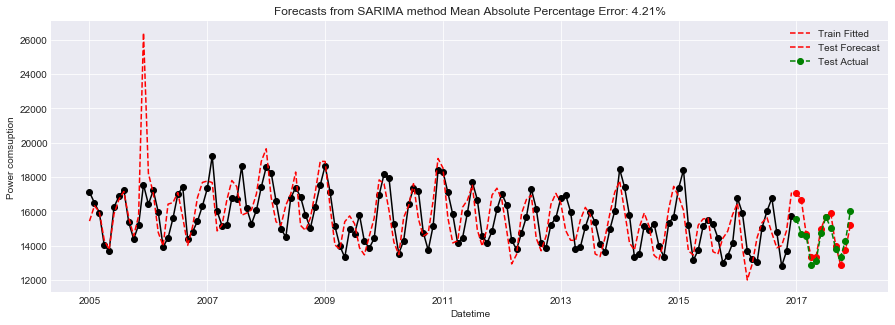

In [28]:
auto_arima_model_plot(data, test)

In this case, Exponential Smoothing Model has a lower Mean Absolute Percentage Error. Therefore, the Exponential Smoothing Model has a better performance.